In [24]:
%reload_ext autoreload
%autoreload 2

import alphabase.io.hdf
import alphadia.extraction.planning
import alphadia.extraction.calibration
from alphabase.statistics.regression import LOESSRegression
import alphatims.bruker

import alphatims.plotting
import alphatims.bruker
import alphatims.utils

import peptdeep.protein.fasta
import os
import logging

In [25]:
temp_folder = '/Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D1_1_2944_temp'
library_path = "/Users/georgwallmann/Documents/data/libraries/2022_09_06_human_trypsin_decoy.hdf"

fasta_lib = peptdeep.protein.fasta.FastaLib()
fasta_lib.load_hdf(library_path, load_mod_seq=True)

dia_data_sets = ['/Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D1_1_2944.d']
dia_data = alphatims.bruker.TimsTOF(dia_data_sets[0])

2022-10-26 10:37:09> Importing data from /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D1_1_2944.d
2022-10-26 10:37:09> Using .d import for /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D1_1_2944.d
2022-10-26 10:37:09> Reading frame metadata for /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D1_1_2944.d
2022-10-26 10:37:09> Reading 19,827 frames with 764,964,665 detector events for /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D1_1_2944.d


100%|██████████| 19827/19827 [00:03<00:00, 5129.33it/s]


2022-10-26 10:37:13> Indexing /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D1_1_2944.d...
2022-10-26 10:37:13> Bruker DLL not available, estimating mobility values
2022-10-26 10:37:13> WARNING: Acquisition software is Bruker otofControl, mz min/max values are assumed to be 5 m/z wider than defined in analysis.tdf!
2022-10-26 10:37:13> Bruker DLL not available, estimating mz values
2022-10-26 10:37:13> Indexing quadrupole dimension
2022-10-26 10:37:13> Successfully imported data from /Users/georgwallmann/Documents/data/brunner2022/diaPASEF_repetitions/20200827_TIMS04_EVO07_AnBr_1ng_dia_rep01_400s_30min_S1-D1_1_2944.d


In [26]:
extraction_plan = alphadia.extraction.planning.AlphaDIAExtractionPlan()
extraction_plan.set_library(fasta_lib)
extraction_plan.load_from_tsv(os.path.join(temp_folder, 'spectrum_hits.tsv'))
extraction_plan.validate()


calibration = alphadia.extraction.calibration.GlobalCalibration()
calibration.set_extraction_plan(extraction_plan)
calibration.set_estimators({'mobility': LOESSRegression(),
                            'rt': LOESSRegression(),
                            'mz': LOESSRegression()})

calibration.fit()
calibration.plot()



AttributeError: 'AlphaDIAExtractionPlan' object has no attribute 'set_library'

In [8]:
import numpy as np
import matplotlib.pyplot as plt

ipp = 4
run_index = 0

#fig, axs = plt.subplots(ncols=len(calibration.estimators[run_index]), nrows=1, figsize=(len(calibration.estimators[run_index])*ipp,ipp))

tolerances = {}


run_df = extraction_plan.precursor_df

for i, (property, estimator) in enumerate(calibration.estimators[run_index].items()):

    target_column, measured_column = calibration.prediction_target[property]
    target_values = run_df[target_column].values
    measured_values = run_df[measured_column].values

    calibration_curve = calibration.predict(0,property,target_values)
    residuals =  measured_values-calibration_curve
    #if property == 'mz':
    #    residuals = residuals / target_values * 10**6

    limits = np.percentile(residuals, [2.5,97.5])
    error = (limits[1]-limits[0])/2
    alphadia.extraction.calibration.density_scatter(target_values,residuals,axs[i],s=2)

    tolerances[property] = error

    #logging.info(f'{property} error: {error}')


In [9]:
rt_values = run_df['rt_values'].to_numpy()
mz_values = run_df['mz_values'].to_numpy()
charges = run_df['charge'].to_numpy()
mobility_values = run_df['mobility_values'].to_numpy()
original_index = run_df['original_index'].to_numpy()

frag_idx = run_df[['frag_start_idx','frag_end_idx']].to_numpy()

In [10]:
print(tolerances)

{'mobility': 0.10145547680575649, 'rt': 815.4278226549457, 'mz': 0.019276472525119458}


In [11]:

fragment_mzs = fasta_lib.fragment_mz_df[['y_z1','b_z1']].to_numpy()
fragment_int = fasta_lib.fragment_intensity_df[['y_z1','b_z1']].to_numpy()

# TODO, data structure only requires indexing inside loop and no memory allocation

@alphatims.utils.njit(nogil=True)
def assemble_fragments(frag_idx, fragment_mzs, fragment_int):

    idx_slice = slice(frag_idx[0],frag_idx[1])

    y_mz_prec = fragment_mzs[idx_slice,0]
    b_mz_prec = fragment_mzs[idx_slice,1]
    
    y_int_prec = fragment_int[idx_slice,0]
    b_int_prec = fragment_int[idx_slice,1]

    mz_prec = np.concatenate((y_mz_prec, b_mz_prec))
    int_prec = np.concatenate((y_int_prec, b_int_prec))

    mz_filtered = mz_prec[int_prec > 0.1]

    return mz_filtered


for i in range(len(frag_idx)):

    mz_filtered = assemble_fragments(frag_idx[i], fragment_mzs, fragment_int)



In [19]:
tolerances['mobility'] = 0.02
tolerances['rt'] = 30
tolerances['mz'] = 0.04

In [20]:
from numba import njit, prange

ISOTOPE_DIFF = 1.0032999999999674

from numba import stencil

@alphatims.utils.njit(nogil=True)
def retrive_dense(frame_index,
            scan_index,
            tof_index,
            quad_slice,
            frame_max_index,
            scan_max_index,
            push_indptr,
            precursor_indices,
            quad_mz_values,
            quad_indptr,
            tof_indices,
            intensity_values,
            cycle_length,
            dense_output,
            isotope,
            zeroth_frame=1,
            ):

    raw_indices = alphatims.bruker.filter_indices(
        frame_slices=frame_index,
        scan_slices=scan_index,
        precursor_slices=np.array([[0, 9, 1]]),
        tof_slices=tof_index,
        quad_slices=quad_slice,
        intensity_slices=np.array([[-np.Inf,np.Inf]]),
        frame_max_index=frame_max_index,
        scan_max_index=scan_max_index,
        push_indptr=push_indptr,
        precursor_indices=precursor_indices,
        quad_mz_values=quad_mz_values,
        quad_indptr=quad_indptr,
        tof_indices=tof_indices,
        intensities=intensity_values
    )



    push_indices = alphatims.bruker.indptr_lookup(
        push_indptr,
        raw_indices,
    )
    
    frame_indices = push_indices // scan_max_index
    scan_indices = push_indices % scan_max_index
    precursor_cycle_indices = (frame_indices-zeroth_frame)//cycle_length
    intensities = intensity_values[raw_indices]
    
    # cycle values
    precursor_cycle_start = frame_index[0,0]//cycle_length
    precursor_cycle_stop = frame_index[0,1]//cycle_length
    precursor_cycle_len = precursor_cycle_stop - precursor_cycle_start

    
    # scan valuesa
    mobility_start = scan_index[0,0]
    mobility_stop = scan_index[0,1]
    mobility_len = mobility_stop - mobility_start

    
    make_dense(intensities, 
                precursor_cycle_indices, 
                scan_indices, 
                precursor_cycle_start, 
                precursor_cycle_len, 
                mobility_start,
                mobility_len,
                dense_output,
                isotope)
    
  
    

@alphatims.utils.njit(nogil=True)
def make_dense(intensities, 
                precursor_cycle_indices, 
                scan_indices, 
                precursor_cycle_start, 
                precursor_cycle_len,
                mobility_start,
                mobility_len,
                
                dense_output,
                isotope):

    

    for i in range(len(intensities)):
        mobility = scan_indices[i]-mobility_start
        precursor_cycle = precursor_cycle_indices[i]-precursor_cycle_start
        dense_output[isotope, mobility, precursor_cycle] += intensities[i]
    #return dense #kernel3(dense)

#[[1. 3. 1.]
# [3. 7. 3.]
# [1. 3. 1.]]
#23.0

@stencil()
def kernel3(a):
    y = a[-1, -1] + a[-1, 1] + a[1, -1] + a[1, 1]
    y += 3*(a[0, 1] + a[1, 0] + a[0, -1] + a[-1, 0])
    y += 7*a[0, 0]
    return y / 23

@alphatims.utils.pjit(thread_count=4, include_progress_callback=True)
def extract_precursor(index, 
                    dia_data_rt,
                    dia_data_mobility,
                    dia_data_mz,

                    dia_data_push_indptr,
                    dia_data_precursor_indices,
                    dia_data_quad_mz_values,
                    dia_data_quad_indptr,
                    dia_data_tof_indices,
                    dia_data_intensity_values,

                    dia_data_frame_max_index,
                    dia_data_scan_max_index,

                    rt_values,
                    rt_tolerance,
                    mobility_values,
                    mobility_tolerance,
                    mz_values,
                    mz_tolerance,
                    charges,

                    frag_idx,
                    fragment_mzs,
                    fragment_int,
                    
                    cycle_length,
                    zeroth_frame
                    ):
    ### rt ###
    # all precursors and fragments should be extracted within the same precursor cycle
    # precursor_cycle: -1  0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3   
    #           frame:  0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17
    #            used:                    x  x  x  x  x  x  x  x  x  x 
    #
    #            precursor_cycle_start: 1
    #            precursor_cycle_stop: 3
    #            precursor_cycle_len: 2
    #            frame_start: 6
    #            frame_stop: 16

    rt = rt_values[index]
    rt_limits = np.array([rt-rt_tolerance, rt+rt_tolerance])
    frame_index = np.searchsorted(dia_data_rt, rt_limits, 'left')
    precursor_cycle = (frame_index-zeroth_frame)//cycle_length

    # the index of the first whole cycle which should be used
    precursor_cycle_start = precursor_cycle[0]

    # the index of the first whole cycle which should not be used
    precursor_cycle_stop = precursor_cycle[1]+1

    # the number of whole cycles extracted
    precursor_cycle_len = precursor_cycle_stop - precursor_cycle_start

    # the first index is the first frame of the cycle which is used
    frame_start = precursor_cycle_start*cycle_length

    # first frame of the next cycle which should not be used
    frame_stop = precursor_cycle_stop*cycle_length

    frame_index_cycle_aware = np.array([[frame_start,frame_stop,1]], dtype='int64')

    ### mobility ###
    
    mobility = mobility_values[index]
    mobility_limits = np.array([mobility+mobility_tolerance,mobility-mobility_tolerance])

    scan_index = dia_data_scan_max_index - np.searchsorted(
                dia_data_mobility[::-1],
                mobility_limits,"right"
            )

    mobility_start = scan_index[0]
    mobility_stop = (scan_index[1]+1)
    mobility_len = mobility_stop - mobility_start
    scan_index = np.array([[mobility_start,mobility_stop,1]], dtype='int64')

    ### mz ###
    # number of isotopes to consider
    num_isotopes = 3

    # get fragment mzs with intensity larger than 0 
    fragment_mzs = assemble_fragments(frag_idx[i], fragment_mzs, fragment_int)
    num_fragments = len(fragment_mzs)

    dense_output = np.zeros((num_isotopes+num_fragments,
                    mobility_len,
                    precursor_cycle_len), dtype=np.float64)

    # iterate all precursors

    charge = charges[i]

    precursor_mz = mz_values[index]

    for isotope_id in range(num_isotopes):

        mz = precursor_mz + 1.0032999999999674/charge
        mz_limits = np.array([mz-mz_tolerance,mz+mz_tolerance])

        mz_limits = np.searchsorted(dia_data_mz, mz_limits, 'left')

        tof_index = np.array([[mz_limits[0],mz_limits[1],1]], dtype='int64')

        retrive_dense(frame_index_cycle_aware,
                        scan_index,
                        tof_index,
                        np.array([[-1.,-1.]]),
                        dia_data_frame_max_index,
                        dia_data_scan_max_index,
                        dia_data_push_indptr,
                        dia_data_precursor_indices,
                        dia_data_quad_mz_values,
                        dia_data_quad_indptr,
                        dia_data_tof_indices,
                        dia_data_intensity_values,
                        cycle_length,
                        
                        dense_output,
                        isotope_id
                        )
        
    for fragment_id in range(num_fragments):

        mz = fragment_mzs[fragment_id]
        mz_limits = np.array([mz-mz_tolerance,mz+mz_tolerance])

        mz_limits = np.searchsorted(dia_data_mz, mz_limits, 'left')

        tof_index = np.array([[mz_limits[0],mz_limits[1],1]], dtype='int64')

        retrive_dense(frame_index_cycle_aware,
                        scan_index,
                        tof_index,
                        np.array([[precursor_mz,precursor_mz]]),
                        dia_data_frame_max_index,
                        dia_data_scan_max_index,
                        dia_data_push_indptr,
                        dia_data_precursor_indices,
                        dia_data_quad_mz_values,
                        dia_data_quad_indptr,
                        dia_data_tof_indices,
                        dia_data_intensity_values,
                        cycle_length,
                        
                        dense_output,
                        fragment_id + num_isotopes
                        )

    



cycle_length = dia_data.cycle.shape[1]



extract_precursor(range(0,5000),
                    dia_data.rt_values,
                    dia_data.mobility_values,
                    dia_data.mz_values,

                    dia_data.push_indptr,
                    dia_data.precursor_indices,
                    dia_data.quad_mz_values,
                    dia_data.quad_indptr,
                    dia_data.tof_indices,
                    dia_data.intensity_values,

                    dia_data.frame_max_index,
                    dia_data.scan_max_index,
                    
                    rt_values,
                    tolerances['rt'],
                    mobility_values,
                    tolerances['mobility'],
                    mz_values,
                    tolerances['mz'],
                    charges,

                    frag_idx,
                    fragment_mzs,
                    fragment_int,

                    cycle_length,
                    1
                    )
    

100%|██████████| 5000/5000 [00:08<00:00, 568.09it/s]


  0%|          | 0/77955 [00:00<?, ?it/s]


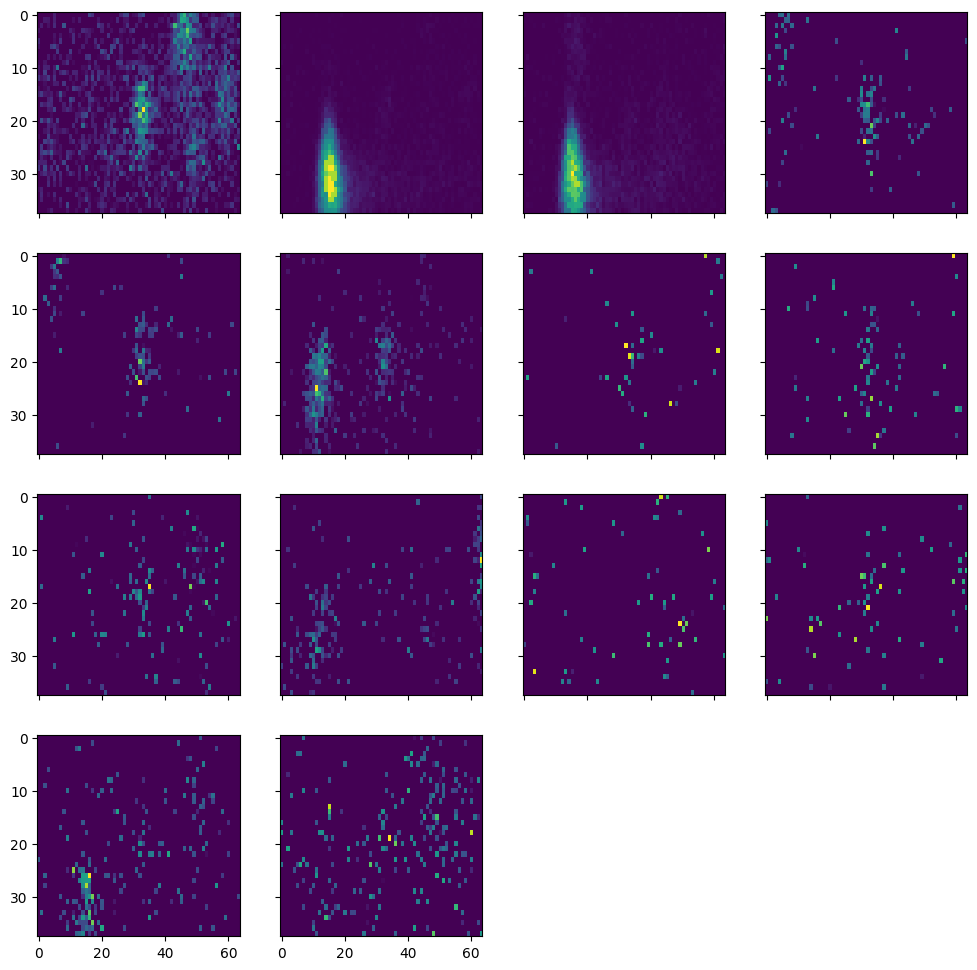

In [21]:

from tqdm import tqdm

for i in tqdm(range(0,len(rt_values))):

    ### rt ###
    # all precursors and fragments should be extracted within the same precursor cycle
    # precursor_cycle: -1  0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3   
    #           frame:  0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17
    #            used:                    x  x  x  x  x  x  x  x  x  x 
    #
    #            precursor_cycle_start: 1
    #            precursor_cycle_stop: 3
    #            precursor_cycle_len: 2
    #            frame_start: 6
    #            frame_stop: 16

    rt = rt_values[i]
    rt_limits = np.array([rt-tolerances['rt'], rt+tolerances['rt']])
    frame_index = dia_data.convert_to_indices(rt_limits,return_frame_indices=True)
    precursor_cycle = (frame_index-dia_data.zeroth_frame)//cycle_length

    # the index of the first whole cycle which should be used
    precursor_cycle_start = precursor_cycle[0]

    # the index of the first whole cycle which should not be used
    precursor_cycle_stop = precursor_cycle[1]+1

    # the number of whole cycles extracted
    precursor_cycle_len = precursor_cycle_stop - precursor_cycle_start

    # the first index is the first frame of the cycle which is used
    frame_start = precursor_cycle_start*cycle_length

    # first frame of the next cycle which should not be used
    frame_stop = precursor_cycle_stop*cycle_length

    frame_index_cycle_aware = np.array([[frame_start,frame_stop,1]], dtype='int64')

    ### mobility ###
    
    mobility = mobility_values[i]
    mobility_limits = np.array([mobility+tolerances['mobility'],mobility-tolerances['mobility']])
    scan_index = dia_data.convert_to_indices(mobility_limits,return_scan_indices=True)
    mobility_start = scan_index[0]
    mobility_stop = (scan_index[1]+1)
    mobility_len = mobility_stop - mobility_start
    scan_index = np.array([[mobility_start,mobility_stop,1]], dtype='int64')

    ### mz ###
    # number of isotopes to consider
    num_isotopes = 3

    # get fragment mzs with intensity larger than 0 
    fragment_mz = assemble_fragments(frag_idx[i], fragment_mzs, fragment_int)
    num_fragments = len(fragment_mz)

    dense_output = np.zeros((num_isotopes+num_fragments,
                    mobility_len,
                    precursor_cycle_len), dtype=np.float64)

    # iterate all precursors

    charge = charges[i]

    precursor_mz = mz_values[i]

    for isotope_id in range(num_isotopes):

        mz = precursor_mz + (isotope_id)*1.0032999999999674/charge
        mz_limits = np.array([mz-tolerances['mz'],mz+tolerances['mz']])


        mz_limits = np.searchsorted(dia_data.mz_values, mz_limits, 'left')

        tof_index = np.array([[mz_limits[0],mz_limits[1],1]], dtype='int64')


        retrive_dense(frame_index_cycle_aware,
                        scan_index,
                        tof_index,
                        np.array([[-1,-1]]),
                        dia_data.frame_max_index,
                        dia_data.scan_max_index,
                        dia_data.push_indptr,
                        dia_data.precursor_indices,
                        dia_data.quad_mz_values,
                        dia_data.quad_indptr,
                        dia_data.tof_indices,
                        dia_data.intensity_values,
                        cycle_length,
                        
                        dense_output,
                        isotope_id
                        )

    
    
    for fragment_id in range(num_fragments):

        mz = fragment_mz[fragment_id]
        mz_limits = np.array([mz-tolerances['mz'],mz+tolerances['mz']])

        mz_limits = np.searchsorted(dia_data.mz_values, mz_limits, 'left')

        tof_index = np.array([[mz_limits[0],mz_limits[1],1]], dtype='int64')

        retrive_dense(frame_index_cycle_aware,
                        scan_index,
                        tof_index,
                        np.array([[precursor_mz,precursor_mz]]),
                        dia_data.frame_max_index,
                        dia_data.scan_max_index,
                        dia_data.push_indptr,
                        dia_data.precursor_indices,
                        dia_data.quad_mz_values,
                        dia_data.quad_indptr,
                        dia_data.tof_indices,
                        dia_data.intensity_values,
                        cycle_length,
                        
                        dense_output,
                        fragment_id + num_isotopes
                        )
    
    ipp = 3
    num_plots = len(dense_output)
    cols = 4
    rows = int(np.ceil(num_plots/cols))

    fig, axs = plt.subplots(nrows=rows, ncols = cols, sharex = True, sharey = True, figsize=(ipp*cols,ipp*rows))

    for k in range(num_plots):
        axs.flat[k].imshow(dense_output[k], aspect='auto')

    for k in range(num_plots, cols*rows):
        fig.delaxes(axs.flat[k])
    break


In [22]:
import numpy as np
df = dia_data[np.array([[5751,6327,1]]),np.array([[641,679,1]]),-1.,189678:189688]
alphatims.plotting.heatmap(df)

:DynamicMap   []
   :RGB   [mz_values,mobility_values]   (R,G,B,A)